In [1]:
from io import StringIO
from pathlib import Path
import requests
import geopandas as gpd
import pandas as pd

import seaborn as sns
%matplotlib inline

Query the ONS Data Portal ArcGIS server to get the list of services

In [2]:
with requests.get('https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/', params={'f': 'json'} ) as r:
    services = pd.DataFrame(r.json()['services'])

We're only interested in Feature Servers for the Westminster Parliamentary Constituencies. The more precise the boundaries, the more accurate the comparison. BFE (full extent) or BFC (full clipped) would be best, but these time out. We're using the BGC instead.

In [3]:
pcon_services = services.loc[
    (services.type == 'FeatureServer') &
    (services.name.str.match(r'Westminster_Parliamentary_Constituencies.*BGC')),
    ['name', 'url']
]

Extract the years and convert to a proper datetime

In [4]:
pcon_services['date'] = (
    pcon_services.name
        .str.extract(r'([^_]*_\d{4})', expand=False)
        .str.replace('_', ' ')
        .pipe(pd.to_datetime, format="mixed"))
pcon_services.sort_values('date')

,name,url,date
2063,Westminster_Parliamentary_Constituencies_Dec_2...,https://services1.arcgis.com/ESMARspQHYMw9BZ9/...,2017-12-01
2071,Westminster_Parliamentary_Constituencies_Dec_2...,https://services1.arcgis.com/ESMARspQHYMw9BZ9/...,2021-12-01
2074,Westminster_Parliamentary_Constituencies_Dec_2...,https://services1.arcgis.com/ESMARspQHYMw9BZ9/...,2022-12-01
3353,Westminster_Parliamentary_Constituencies_July_...,https://services1.arcgis.com/ESMARspQHYMw9BZ9/...,2024-07-01


Let's extract the urls for the feature servers

In [5]:
url_2022 = pcon_services.loc[pcon_services.name.str.contains('Dec_2022')].iat[0, 1] + '/0/query'
url_2024 = pcon_services.loc[pcon_services.name.str.contains('July_2024')].iat[0, 1] + '/0/query'

Now we need to query the service to get the geojson file. This function will work for both.

In [6]:
def get_geo(url, fields=None):
    with requests.get(url, params={
        'where': '1=1',
        'outFields': fields,
        'f': 'geojson',
        'outSR': '27700'
    }) as r:
        return gpd.read_file(StringIO(r.text))

We'll store them as two separate GeoDataFrames. These are projected to OS National Grid, which can be reliably used to calculate area.

In [7]:
old = get_geo(url_2022, 'PCON22CD')
new = get_geo(url_2024, 'PCON24CD')

We'll store the area of the new constituency for future reference.

In [8]:
new['total_area'] = new.area


We now need to find which old constituencies intersect with the new ones. This creates a new geodataframe with a line per intersected area. 

In [9]:
intersection = new.overlay(old, how="intersection", keep_geom_type=True)

/home/giles/.local/share/virtualenvs/yff-data-pipeline-9Di0ELhI/lib/python3.10/site-packages/geopandas/geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


We calculate the weightings by diving the area of the intersection by the area of the new constituency.

In [10]:
intersection['weight'] = intersection.area / intersection.total_area

We'll extract the results as a data frame, then set the index and round to 3 decimal places (to nearest 0.1%), before removing any weighting that are zero.

In [11]:
mapping = intersection.loc[:, ['PCON24CD', 'PCON22CD', 'weight']].set_index('PCON24CD').round(3).query('weight > 0')

We'll save the CSV for future reference

In [12]:
DATA_DIR = Path('../../data/reference')
mapping.to_csv(DATA_DIR / 'pcon_mapping.csv')

We can visualise the weightings as a heatmap, which shows a diagonal line mapping

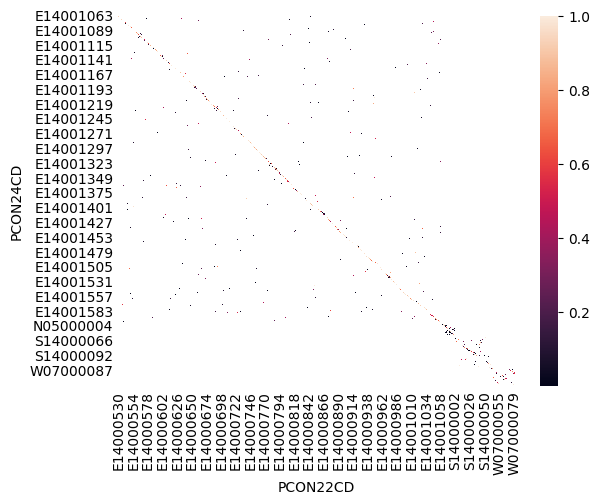

In [13]:
plot = sns.heatmap(mapping.pivot(columns="PCON22CD").droplevel(0, axis=1))
plot.tick_params('both', length=0)